### Initial model

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import string
import scipy
import keras
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC


Using TensorFlow backend.


### Load data

In [3]:
# Input data
train_df = pd.read_csv('data/train_clean.csv')
X = train_df['comment_clean']
y = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

To evaluate initial model we will need a validation dataset. We can split given training dataset - to train/validation sets

In [4]:
# Split train data to train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2)

In [5]:
print('Train set shape:', X_train.shape)
print('Validation set shape:', X_val.shape)

Train set shape: (143608,)
Validation set shape: (15957,)


### Vectorize text

In order to use text data in any of algorithms, first we need to vectorize it. For this I will use quite popular and simple text vectorization algoritm TFIDF. This will result in huge feature vector (I limited it to 10k values) for each comment. This vector will have values for each word (limited to 10k words) and that word's score in each comment. To use these feature vectors further I will use LSA for dimentionality reduction.

In [6]:
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_vec = tfidf.fit_transform(X_train)

In [7]:
lsa = TruncatedSVD(n_components=10)
X_train_lsa = lsa.fit_transform(X_train_vec)
print('Training feature vectors shape:', X_train_lsa.shape)

Training feature vectors shape: (143608, 10)


### Prepare validation dataset

Apply same transformations to validation dataset

In [8]:
X_val_vec = tfidf.transform(X_val)
X_val_lsa = lsa.transform(X_val_vec)

### Build simple NN model

For multilabel classification task let's build a simple one hidden layer NN model to get initial results and see where we can improve. If needed, later on we can iterate on the model, edit hyper parameters to find better architecture for this task. 

In [9]:
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


### Training

In [11]:
hist = model.fit(X_train_lsa, y_train.values, validation_data=(X_val_lsa, y_val.values), epochs=20)

Train on 143608 samples, validate on 15957 samples
Epoch 1/20
143608/143608 [==============================] - 6s 42us/sample - loss: 0.1403 - auc: 0.8350 - val_loss: 0.0963 - val_auc: 0.9196
Epoch 2/20
143608/143608 [==============================] - 6s 39us/sample - loss: 0.0962 - auc: 0.9154 - val_loss: 0.0912 - val_auc: 0.9231loss: 0.0963 - auc:
Epoch 3/20
143608/143608 [==============================] - 5s 38us/sample - loss: 0.0934 - auc: 0.9185 - val_loss: 0.0896 - val_auc: 0.9247
Epoch 4/20
143608/143608 [==============================] - 5s 36us/sample - loss: 0.0920 - auc: 0.9206 - val_loss: 0.0885 - val_auc: 0.9268
Epoch 5/20
143608/143608 [==============================] - 5s 35us/sample - loss: 0.0908 - auc: 0.9229 - val_loss: 0.0875 - val_auc: 0.9287
Epoch 6/20
143608/143608 [==============================] - 5s 35us/sample - loss: 0.0899 - auc: 0.9247 - val_loss: 0.0867 - val_auc: 0.9304
Epoch 7/20
143608/143608 [==============================] - 5s 35us/sample - loss: 0

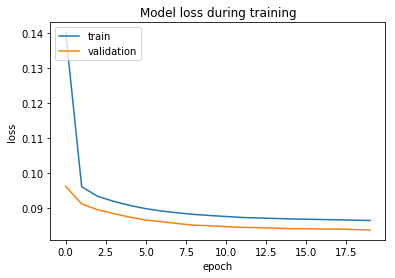

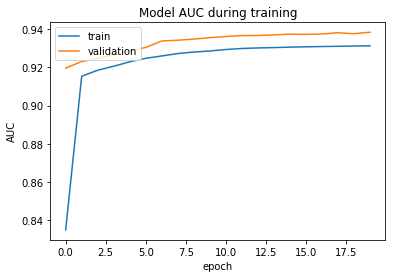

In [12]:
# Plot training
# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# AUC
plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
plt.title('Model AUC during training')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We can see that it was quite an easy task for the network to train and reach high accuracy. That is because alot of work has already been done in vectorization and dimentionality reduction steps. Let's evaluate model performance on auc metric.

### Evaluation

In [13]:
def eval_auc(y, pred):
    auc_list = []
    for i in range(6):
    
        fpr, tpr, _ = sklearn.metrics.roc_curve(y.iloc[:, i].values, pred[:, i])
        auc_list.append(sklearn.metrics.auc(fpr, tpr))
    
    print('AUC for each class:')
    print(np.array(auc_list))
    print('Mean AUC:', np.mean(auc_list))

In [14]:
pred_val = model.predict(X_val_lsa)
eval_auc(y_val, pred_val)

AUC for each class:
[0.88118527 0.96923089 0.92667259 0.91198555 0.91344838 0.89185965]
Mean AUC: 0.9157303882991544


Results seem to be great for the first try, almost high enough to reach the goal of 0.95 on AUC metric. The model seems to be suficient and most likelly missing performance can be achieved with hyperparameter tuning.

Let's check results manually (sanity check) and see what toxic comments has out algorithm found. Added "_p" to column names to mark the predictions of model, classses without "_p" are the true labels. 

In [15]:
check_df = pd.DataFrame(np.hstack((pred_val, y_val)), columns=['toxic_p', 'severe_toxic_p', 'obscene_p', 'threat_p', 'insult_p', 'identity_hate_p', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
check_df['comments'] = X_val.values

In [16]:
check_df[check_df['toxic_p'] > 0.5].head()

,toxic_p,severe_toxic_p,obscene_p,threat_p,insult_p,identity_hate_p,toxic,severe_toxic,obscene,threat,insult,identity_hate,comments
25,0.908272,0.159997,0.804529,0.052221,0.557649,0.149684,1.0,1.0,1.0,0.0,1.0,0.0,u suck u suck'u sucku suck'u suck u suck'u suc...
38,0.940123,0.155010,0.872172,0.047489,0.647327,0.138170,1.0,1.0,1.0,0.0,1.0,1.0,gay everyone is emailing me about deep shadow ...
63,0.996969,0.282089,0.991198,0.047464,0.790172,0.157822,1.0,0.0,1.0,0.0,1.0,0.0,hahahah sucker quit your bitchin for once and ...
68,1.000000,0.484863,1.000000,0.012493,0.936307,0.103661,1.0,0.0,1.0,0.0,1.0,0.0,faaa q means fuck you to
76,0.989069,0.346434,0.969021,0.104021,0.758553,0.268880,1.0,1.0,1.0,1.0,1.0,0.0,eat shit fucko suck my asshole then die horrib...
